In [1]:
%autosave 0
import numpy as np 
import pandas as pd 
from pandas import read_csv, DataFrame
from math import sqrt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import Pipeline

import keras
from keras.models import Sequential
from keras import Sequential
from keras.layers import Dense, Dropout, Input, Activation
from keras import metrics
from keras import optimizers
from keras import regularizers

from keras.wrappers.scikit_learn import KerasRegressor

import seaborn as sns
import matplotlib.pyplot as plt

# ignore Warning
import warnings
warnings.filterwarnings("ignore") 



Autosave disabled


Using TensorFlow backend.


In [2]:
#### Mettre la variable sur True si recherche des paramétres opti, mais l'opération dure environ 45 minutes
lookForOptimiz = True

In [3]:
df_train = read_csv('new_Basetrain.csv')
df_Kagg = read_csv('new_kaggtest.csv')

submission = pd.DataFrame()
submission["Id"]= df_Kagg["Id"]

# Preparation du split

In [4]:
X_train = df_train

V_train = df_train['target'].values
F_train = df_train.drop(['target','SalePriceLog'], axis=1)

F_train

,Id,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,...,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalSF,T_garage,T_Overall
0,1,856,854,0,1,3,0,4,3,706.0,...,8,856.0,856,0,2003,2003,2,2566.0,14.0,11
1,2,1262,0,0,1,3,0,4,1,978.0,...,6,1262.0,1262,298,1976,1976,1,2524.0,14.0,13
2,3,920,866,0,1,3,0,4,2,486.0,...,6,920.0,920,0,2001,2002,2,2706.0,14.0,11
3,4,961,756,0,1,3,0,1,3,216.0,...,7,756.0,961,0,1915,1970,0,2473.0,16.0,11
4,5,1145,1053,0,1,4,0,4,0,655.0,...,9,1145.0,1145,192,2000,2000,2,3343.0,15.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,1456,953,694,0,1,3,0,4,3,0.0,...,7,953.0,953,0,1999,2000,1,2600.0,14.0,10
1449,1457,2073,0,0,1,3,0,4,3,790.0,...,7,1542.0,2073,349,1978,1988,4,3615.0,15.0,11
1450,1458,1188,1152,0,1,4,0,1,3,275.0,...,9,1152.0,1188,0,1941,2006,4,3492.0,13.0,15
1451,1459,1078,0,0,1,2,0,4,2,49.0,...,5,1078.0,1078,366,1950,1996,4,2156.0,14.0,10


In [5]:
V_train

array([208500., 181500., 223500., ..., 266500., 142125., 147500.])

In [6]:
seed = 42
np.random.seed(seed)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(F_train, V_train, test_size=0.3, random_state=seed)

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_val = scale.transform(X_val)
df_Kagg = scale.transform(df_Kagg)

y_scale = StandardScaler()
y_scale.fit(y_train.reshape(-1, 1))
y_train = y_scale.transform(y_train.reshape(-1, 1))
y_val_resc = y_scale.transform(y_val.reshape(-1, 1))

df_Kagg

array([[ 1.71548419, -0.73817939, -0.79127308, ..., -1.04410074,
        -0.06083723, -0.41119226],
       [ 1.71783886,  0.44538301, -0.79127308, ...,  0.11658472,
        -0.06083723,  0.17946103],
       [ 1.72019354, -0.65071057,  0.82750105, ..., -0.01663032,
        -0.98429198, -1.00184555],
       ...,
       [ 5.14389644,  0.15837596, -0.79127308, ..., -0.16039704,
         0.40089014,  0.17946103],
       [ 5.14625112, -0.53590775, -0.79127308, ..., -0.90692882,
        -3.29292884, -1.00184555],
       [ 5.1486058 , -0.46483934,  1.52719943, ...,  0.56239345,
        -0.52256461,  0.17946103]])

# Recherche des paramétres opti du réseau

In [8]:
sgd = optimizers.SGD(lr=0.01, clipvalue=0.5)

In [9]:
def create_model():
    model = Sequential()
    model.add(Dense(200, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l1(0.01)))
    model.add(Activation('relu')) 
#     model.add(Dense(100, kernel_initializer='normal'))
#     model.add(Activation('relu'))
    model.add(Dense(1, kernel_initializer='normal',kernel_regularizer=regularizers.l1(0.01)))
    model.compile(loss='mean_squared_error', optimizer=sgd)
    return model

In [10]:
def BestParams():
    estimators = []
    #estimators.append(('pf', PolynomialFeatures(interaction_only=True,include_bias=False)))
    estimators.append(('ss', StandardScaler()))
    estimators.append(('nn', KerasRegressor(build_fn=create_model, epochs=10, batch_size=5, verbose=0)))
    nn_pipe = Pipeline(estimators)

    nn_param_grid = {'nn__epochs': [1000,1500,2000],'nn__batch_size':[5,100,200]}

    gs_nn = GridSearchCV(nn_pipe, nn_param_grid,verbose=0, cv=3)
    print('Ok')
    gs_nn.fit(X_train, y_train)
    return gs_nn.best_params_

In [11]:
X_train.shape, y_train.shape

((1017, 83), (1017, 1))

In [12]:
if lookForOptimiz : 
    best = BestParams()
    print(best)

Ok
{'nn__batch_size': 200, 'nn__epochs': 2000}


# Creation du modèle

In [35]:
model = create_model()

In [36]:
m_fti = model.fit(X_train, y_train, epochs=2000, batch_size=200)

Epoch 1/2000
1017/1017 [==============================] - 0s 140us/step - loss: 12.9554
Epoch 2/2000
1017/1017 [==============================] - 0s 29us/step - loss: 12.4266
Epoch 3/2000
1017/1017 [==============================] - 0s 35us/step - loss: 12.1891
Epoch 4/2000
1017/1017 [==============================] - 0s 33us/step - loss: 12.0462
Epoch 5/2000
1017/1017 [==============================] - 0s 30us/step - loss: 11.9231
Epoch 6/2000
1017/1017 [==============================] - 0s 39us/step - loss: 11.8088
Epoch 7/2000
1017/1017 [==============================] - 0s 34us/step - loss: 11.6994
Epoch 8/2000
1017/1017 [==============================] - 0s 33us/step - loss: 11.5922
Epoch 9/2000
1017/1017 [==============================] - 0s 33us/step - loss: 11.4890
Epoch 10/2000
1017/1017 [==============================] - 0s 35us/step - loss: 11.3931
Epoch 11/2000
1017/1017 [==============================] - 0s 31us/step - loss: 11.2907
Epoch 12/2000
1017/1017 [===============

Epoch 95/2000
1017/1017 [==============================] - 0s 34us/step - loss: 4.7142
Epoch 96/2000
1017/1017 [==============================] - 0s 30us/step - loss: 4.6550
Epoch 97/2000
1017/1017 [==============================] - 0s 31us/step - loss: 4.5954
Epoch 98/2000
1017/1017 [==============================] - 0s 35us/step - loss: 4.5363
Epoch 99/2000
1017/1017 [==============================] - 0s 33us/step - loss: 4.4777
Epoch 100/2000
1017/1017 [==============================] - 0s 30us/step - loss: 4.4198
Epoch 101/2000
1017/1017 [==============================] - 0s 29us/step - loss: 4.3619
Epoch 102/2000
1017/1017 [==============================] - 0s 28us/step - loss: 4.3048
Epoch 103/2000
1017/1017 [==============================] - 0s 32us/step - loss: 4.2479
Epoch 104/2000
1017/1017 [==============================] - 0s 31us/step - loss: 4.1917
Epoch 105/2000
1017/1017 [==============================] - 0s 31us/step - loss: 4.1359
Epoch 106/2000
1017/1017 [===========

1017/1017 [==============================] - 0s 32us/step - loss: 0.9150
Epoch 189/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.8933
Epoch 190/2000
1017/1017 [==============================] - 0s 35us/step - loss: 0.8716
Epoch 191/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.8523
Epoch 192/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.8307
Epoch 193/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.8101
Epoch 194/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.7901
Epoch 195/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.7711
Epoch 196/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.7524
Epoch 197/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.7342
Epoch 198/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.7155
Epoch 199/2000
1017/1017 [=====================

1017/1017 [==============================] - 0s 40us/step - loss: 0.2486
Epoch 282/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.2485
Epoch 283/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.2466
Epoch 284/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.2456
Epoch 285/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.2523
Epoch 286/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.2459
Epoch 287/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.2452
Epoch 288/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.2438
Epoch 289/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.2518
Epoch 290/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.2447
Epoch 291/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.2424
Epoch 292/2000
1017/1017 [=====================

1017/1017 [==============================] - 0s 35us/step - loss: 0.2112
Epoch 375/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.2073
Epoch 376/2000
1017/1017 [==============================] - 0s 28us/step - loss: 0.2056
Epoch 377/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.2053
Epoch 378/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.2049
Epoch 379/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.2052
Epoch 380/2000
1017/1017 [==============================] - 0s 27us/step - loss: 0.2038
Epoch 381/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.2032
Epoch 382/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.2030
Epoch 383/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.2026
Epoch 384/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.2028
Epoch 385/2000
1017/1017 [=====================

1017/1017 [==============================] - 0s 34us/step - loss: 0.1827
Epoch 468/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1827
Epoch 469/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1817
Epoch 470/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1817
Epoch 471/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1812
Epoch 472/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1819
Epoch 473/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1814
Epoch 474/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1822
Epoch 475/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1812
Epoch 476/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1812
Epoch 477/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1808
Epoch 478/2000
1017/1017 [=====================

1017/1017 [==============================] - 0s 33us/step - loss: 0.1712
Epoch 561/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1674
Epoch 562/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1706
Epoch 563/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1674
Epoch 564/2000
1017/1017 [==============================] - 0s 28us/step - loss: 0.1671
Epoch 565/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1673
Epoch 566/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1677
Epoch 567/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1663
Epoch 568/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1664
Epoch 569/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1661
Epoch 570/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1661
Epoch 571/2000
1017/1017 [=====================

1017/1017 [==============================] - 0s 32us/step - loss: 0.1577
Epoch 654/2000
1017/1017 [==============================] - 0s 27us/step - loss: 0.1571
Epoch 655/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1599
Epoch 656/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1569
Epoch 657/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1564
Epoch 658/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1569
Epoch 659/2000
1017/1017 [==============================] - 0s 28us/step - loss: 0.1566
Epoch 660/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1564
Epoch 661/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1580
Epoch 662/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1573
Epoch 663/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1560
Epoch 664/2000
1017/1017 [=====================

1017/1017 [==============================] - 0s 32us/step - loss: 0.1496
Epoch 747/2000
1017/1017 [==============================] - 0s 28us/step - loss: 0.1512
Epoch 748/2000
1017/1017 [==============================] - 0s 28us/step - loss: 0.1494
Epoch 749/2000
1017/1017 [==============================] - 0s 26us/step - loss: 0.1493
Epoch 750/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1490
Epoch 751/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1493
Epoch 752/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1494
Epoch 753/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1489
Epoch 754/2000
1017/1017 [==============================] - 0s 28us/step - loss: 0.1518
Epoch 755/2000
1017/1017 [==============================] - 0s 26us/step - loss: 0.1490
Epoch 756/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1488
Epoch 757/2000
1017/1017 [=====================

1017/1017 [==============================] - 0s 31us/step - loss: 0.1455
Epoch 840/2000
1017/1017 [==============================] - 0s 36us/step - loss: 0.1446
Epoch 841/2000
1017/1017 [==============================] - 0s 36us/step - loss: 0.1449
Epoch 842/2000
1017/1017 [==============================] - 0s 37us/step - loss: 0.1452
Epoch 843/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1453
Epoch 844/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1449
Epoch 845/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1447
Epoch 846/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1449
Epoch 847/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1451
Epoch 848/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1444
Epoch 849/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1449
Epoch 850/2000
1017/1017 [=====================

1017/1017 [==============================] - 0s 29us/step - loss: 0.1440
Epoch 933/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1428
Epoch 934/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1424
Epoch 935/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1426
Epoch 936/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1426
Epoch 937/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1426
Epoch 938/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1417
Epoch 939/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1422
Epoch 940/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1417
Epoch 941/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1422
Epoch 942/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1423
Epoch 943/2000
1017/1017 [=====================

Epoch 1025/2000
1017/1017 [==============================] - 0s 35us/step - loss: 0.1405
Epoch 1026/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1405
Epoch 1027/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1403
Epoch 1028/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1406
Epoch 1029/2000
1017/1017 [==============================] - 0s 36us/step - loss: 0.1421
Epoch 1030/2000
1017/1017 [==============================] - 0s 35us/step - loss: 0.1418
Epoch 1031/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1412
Epoch 1032/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1406
Epoch 1033/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1408
Epoch 1034/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1413
Epoch 1035/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1406
Epoch 1036/2000
1017/

1017/1017 [==============================] - 0s 30us/step - loss: 0.1397
Epoch 1118/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1401
Epoch 1119/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1425
Epoch 1120/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1400
Epoch 1121/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1399
Epoch 1122/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1393
Epoch 1123/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1398
Epoch 1124/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1395
Epoch 1125/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1392
Epoch 1126/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1397
Epoch 1127/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1400
Epoch 1128/2000
1017/1017 [==========

1017/1017 [==============================] - 0s 31us/step - loss: 0.1393
Epoch 1210/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1386
Epoch 1211/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1389
Epoch 1212/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1390
Epoch 1213/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1389
Epoch 1214/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1387
Epoch 1215/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1388
Epoch 1216/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1389
Epoch 1217/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1427
Epoch 1218/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1396
Epoch 1219/2000
1017/1017 [==============================] - 0s 28us/step - loss: 0.1388
Epoch 1220/2000
1017/1017 [==========

1017/1017 [==============================] - 0s 36us/step - loss: 0.1378
Epoch 1302/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1408
Epoch 1303/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1390
Epoch 1304/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1386
Epoch 1305/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1390
Epoch 1306/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1381
Epoch 1307/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1383
Epoch 1308/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1387
Epoch 1309/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1387
Epoch 1310/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1383
Epoch 1311/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1394
Epoch 1312/2000
1017/1017 [==========

1017/1017 [==============================] - 0s 27us/step - loss: 0.1381
Epoch 1394/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1381
Epoch 1395/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1384
Epoch 1396/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1386
Epoch 1397/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1387
Epoch 1398/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1388
Epoch 1399/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1410
Epoch 1400/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1389
Epoch 1401/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1384
Epoch 1402/2000
1017/1017 [==============================] - 0s 28us/step - loss: 0.1412
Epoch 1403/2000
1017/1017 [==============================] - 0s 35us/step - loss: 0.1391
Epoch 1404/2000
1017/1017 [==========

1017/1017 [==============================] - 0s 28us/step - loss: 0.1379
Epoch 1486/2000
1017/1017 [==============================] - 0s 28us/step - loss: 0.1375
Epoch 1487/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1385
Epoch 1488/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1387
Epoch 1489/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1383
Epoch 1490/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1389
Epoch 1491/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1396
Epoch 1492/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1384
Epoch 1493/2000
1017/1017 [==============================] - 0s 28us/step - loss: 0.1381
Epoch 1494/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1387
Epoch 1495/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1383
Epoch 1496/2000
1017/1017 [==========

1017/1017 [==============================] - 0s 31us/step - loss: 0.1372
Epoch 1578/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1402
Epoch 1579/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1375
Epoch 1580/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1375
Epoch 1581/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1414
Epoch 1582/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1382
Epoch 1583/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1375
Epoch 1584/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1380
Epoch 1585/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1377
Epoch 1586/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1389
Epoch 1587/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1376
Epoch 1588/2000
1017/1017 [==========

1017/1017 [==============================] - 0s 35us/step - loss: 0.1382
Epoch 1670/2000
1017/1017 [==============================] - 0s 38us/step - loss: 0.1374
Epoch 1671/2000
1017/1017 [==============================] - 0s 41us/step - loss: 0.1389
Epoch 1672/2000
1017/1017 [==============================] - 0s 41us/step - loss: 0.1382
Epoch 1673/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1377
Epoch 1674/2000
1017/1017 [==============================] - 0s 36us/step - loss: 0.1382
Epoch 1675/2000
1017/1017 [==============================] - 0s 38us/step - loss: 0.1377
Epoch 1676/2000
1017/1017 [==============================] - 0s 38us/step - loss: 0.1372
Epoch 1677/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1382
Epoch 1678/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1373
Epoch 1679/2000
1017/1017 [==============================] - 0s 40us/step - loss: 0.1378
Epoch 1680/2000
1017/1017 [==========

1017/1017 [==============================] - 0s 33us/step - loss: 0.1387
Epoch 1762/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1380
Epoch 1763/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1381
Epoch 1764/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1382
Epoch 1765/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1379
Epoch 1766/2000
1017/1017 [==============================] - 0s 40us/step - loss: 0.1372
Epoch 1767/2000
1017/1017 [==============================] - 0s 37us/step - loss: 0.1380
Epoch 1768/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1374
Epoch 1769/2000
1017/1017 [==============================] - 0s 34us/step - loss: 0.1373
Epoch 1770/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1371
Epoch 1771/2000
1017/1017 [==============================] - 0s 35us/step - loss: 0.1388
Epoch 1772/2000
1017/1017 [==========

1017/1017 [==============================] - 0s 30us/step - loss: 0.1369
Epoch 1854/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1371
Epoch 1855/2000
1017/1017 [==============================] - 0s 35us/step - loss: 0.1432
Epoch 1856/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1374
Epoch 1857/2000
1017/1017 [==============================] - 0s 28us/step - loss: 0.1387
Epoch 1858/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1386
Epoch 1859/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1373
Epoch 1860/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1370
Epoch 1861/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1401
Epoch 1862/2000
1017/1017 [==============================] - 0s 29us/step - loss: 0.1371
Epoch 1863/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1372
Epoch 1864/2000
1017/1017 [==========

1017/1017 [==============================] - 0s 31us/step - loss: 0.1364
Epoch 1946/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1361
Epoch 1947/2000
1017/1017 [==============================] - 0s 33us/step - loss: 0.1366
Epoch 1948/2000
1017/1017 [==============================] - 0s 35us/step - loss: 0.1375
Epoch 1949/2000
1017/1017 [==============================] - 0s 32us/step - loss: 0.1369
Epoch 1950/2000
1017/1017 [==============================] - 0s 31us/step - loss: 0.1370
Epoch 1951/2000
1017/1017 [==============================] - 0s 28us/step - loss: 0.1372
Epoch 1952/2000
1017/1017 [==============================] - 0s 28us/step - loss: 0.1375
Epoch 1953/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1402
Epoch 1954/2000
1017/1017 [==============================] - 0s 30us/step - loss: 0.1369
Epoch 1955/2000
1017/1017 [==============================] - 0s 28us/step - loss: 0.1367
Epoch 1956/2000
1017/1017 [==========

<function matplotlib.pyplot.show(*args, **kw)>

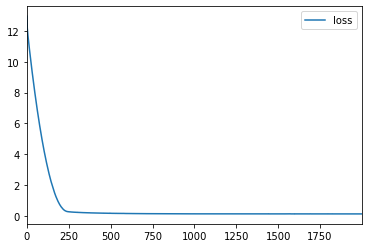

In [37]:
DataFrame(m_fti.history).plot()
plt.grid = True
plt.show

In [38]:
X_val.shape

(436, 83)

In [39]:
pred = model.predict(X_val)
pred = y_scale.inverse_transform(pred)

In [40]:
RMSE = np.sqrt(MSE(pred,y_val))
print(RMSE.round(4))

21840.2545


In [41]:
pred_kagg = model.predict(df_Kagg)

In [42]:
pred_kagg.shape

(1459, 1)

In [43]:
pred_kagg = y_scale.inverse_transform(pred_kagg)

In [44]:
pred_kagg


array([[121723.305],
       [156548.27 ],
       [177242.45 ],
       ...,
       [159828.03 ],
       [113446.24 ],
       [217064.22 ]], dtype=float32)

In [45]:
submission["SalePrice"]= pred_kagg
submission.to_csv("new_kagg10.csv", index= False)

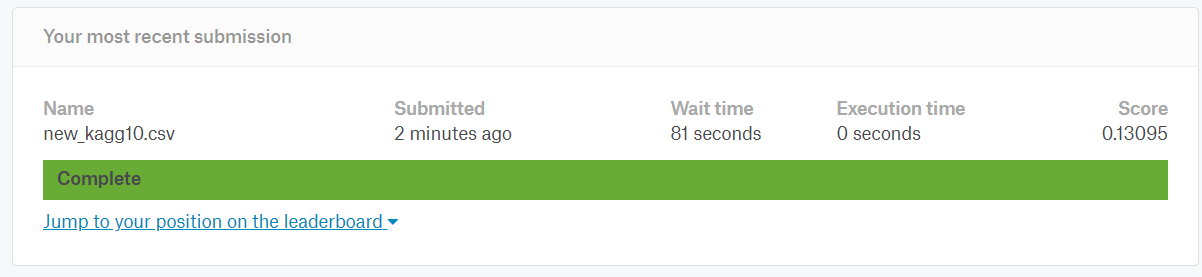

In [46]:
from IPython.display import Image
Image('png/Neuro.png')